Part 2: Multi-label classification, imbalanced learning, and more
----
Not all classification tasks in astronomy can neatly be reduced to binary classification problems, and we limit the predictive power of our models by doing so. In this notebook we'll tackle a more complex example, using the same dataset downloaded in Part 1.

Elements covered here:
- Imbalanced learning: how to robustly train ML models on datasets with over/under-represented classes
- Multi-label classification: how to generalise the sigmoid introduced to more complex problems.

In [1]:
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# helpful aliases to write shorter code
tfk = tf.keras
tfkl = tf.keras.layers

2022-07-24 16:31:40.686716: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-24 16:31:40.777016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-24 16:31:40.777062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load data into memory

with h5py.File("../data/Galaxy10.h5", "r") as data:
    images = np.array(data["images"])
    labels = np.array(data["ans"])

class_label_map = {
    "0": "Disk, Face-on, No Spiral",
    "1": "Smooth, Completely round",
    "2": "Smooth, in-between round",
    "3": "Smooth, Cigar shaped",
    "4": "Disk, Edge-on, Rounded Bulge",
    "5": "Disk, Edge-on, Boxy Bulge",
    "6": "Disk, Edge-on, No Bulge",
    "7": "Disk, Face-on, Tight Spiral",
    "8": "Disk, Face-on, Medium Spiral",
    "9": "Disk, Face-on, Loose Spiral",
}

In [3]:
normpoint = images.max() / 2
array_sharded = np.array_split(images, 100, axis=0)
images = np.concatenate([(a - normpoint)/normpoint for a in array_sharded])

One-hot encoding
---
We're now going to predict multiple classes each with their own probability, so we need to do some reformatting of our labels - we'll use a 'one-hot' encoding. The output will be a vector `(n_classes, )` in dimension, being zero in all entries apart from one, that corresponds to the given class.

In [4]:
onehot_labels = tf.keras.utils.to_categorical(labels)
n_classes = onehot_labels.shape[1]

Proceeding as before

In [5]:
# Pick your own seed!
random_seed = 42

# 80% of images for training on, 10% as test, 10% as validation
images_train, images_test, labels_train, labels_test = train_test_split(
    images, onehot_labels, test_size=0.2, random_state=42
)
images_test, images_val, labels_test, labels_val = train_test_split(
    images_test, labels_test, test_size=0.5, random_state=42
)

for data, name in zip(
    [images_train, images_val, images_test], ["train", "val", "test"]
):
    print(f"{name.ljust(7)}: {len(data)}")

train  : 17428
val    : 2179
test   : 2178


In [6]:
model = tfk.Sequential(
    [
        tfkl.Conv2D(8, (3, 3), activation="relu", name="conv1", input_shape=images.shape[1:]),
        tfkl.Conv2D(8, (3, 3), activation="relu", name="conv2"),
        tfkl.MaxPooling2D(pool_size=(4, 4), padding='valid'),
        tfkl.Conv2D(16, (3, 3), activation="relu", name="conv3"),
        tfkl.Conv2D(16, (3, 3), activation="relu", name="conv4"),
        tfkl.MaxPooling2D((4, 4), padding='valid'),
        tfkl.Flatten(),
        tfkl.Dense(64, activation='relu', name='fc_1'),
        tfkl.Dense(n_classes, activation='softmax', name='output')

    ]
)

model.summary()

# optimiser: let's use Adam with `learning_rate` = 3e-4. Why not try a different one from https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
optim = tfk.optimizers.Adam(learning_rate=3e-4)

# loss: binary classification problem, so binary cross-entropy is the way to go. See s1_linearmodelstoml for an introduction to this.
loss = tfk.losses.CategoricalCrossentropy()

# metrics: as humans the Accuracy is probably our first thought! But there's a full range of metrics available at https://www.tensorflow.org/api_docs/python/tf/keras/metrics.
# why not try swapping in/adding Precision, Recall, KLDivergence etc.
metrics = [tfk.metrics.CategoricalAccuracy(), tfk.metrics.AUC()]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 67, 67, 8)         224       
                                                                 
 conv2 (Conv2D)              (None, 65, 65, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv3 (Conv2D)              (None, 14, 14, 16)        1168      
                                                                 
 conv4 (Conv2D)              (None, 12, 12, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                    

2022-07-24 16:32:21.930804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-24 16:32:21.930907: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-24 16:32:21.930951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ragnarok): /proc/driver/nvidia/version does not exist
2022-07-24 16:32:21.931983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The joy of ML frameworks: we can reuse almost all of the code from our binary example, with a few switches to change the output layer to accomodate this.

In [7]:
history = model.fit(x=images_train, y=labels_train, batch_size=32, verbose=1, validation_data=(images_val, labels_val), shuffle=True, epochs=30)

Epoch 1/30
545/545 [==============================] - 17s 27ms/step - loss: 1.6579 - categorical_accuracy: 0.3553 - auc: 0.8394 - val_loss: 1.4311 - val_categorical_accuracy: 0.4621 - val_auc: 0.8886
Epoch 2/30
545/545 [==============================] - 14s 26ms/step - loss: 1.2871 - categorical_accuracy: 0.5164 - auc: 0.9075 - val_loss: 1.2109 - val_categorical_accuracy: 0.5034 - val_auc: 0.9212
Epoch 3/30
545/545 [==============================] - 14s 26ms/step - loss: 1.0772 - categorical_accuracy: 0.6027 - auc: 0.9352 - val_loss: 1.0000 - val_categorical_accuracy: 0.6420 - val_auc: 0.9450
Epoch 4/30
545/545 [==============================] - 14s 26ms/step - loss: 0.9818 - categorical_accuracy: 0.6413 - auc: 0.9458 - val_loss: 0.9253 - val_categorical_accuracy: 0.6531 - val_auc: 0.9517
Epoch 5/30
545/545 [==============================] - 14s 26ms/step - loss: 0.9224 - categorical_accuracy: 0.6682 - auc: 0.9519 - val_loss: 0.8677 - val_categorical_accuracy: 0.6971 - val_auc: 0.9576


In [8]:
train_metrics = history.history

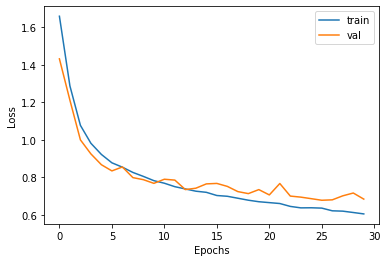

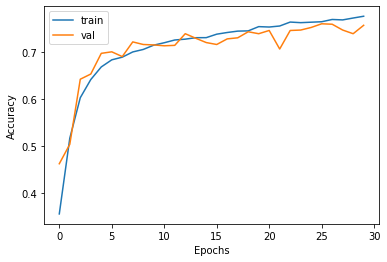

In [9]:
plt.plot(train_metrics['loss'], label='train')
plt.plot(train_metrics['val_loss'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(train_metrics['categorical_accuracy'], label='train')
plt.plot(train_metrics['val_categorical_accuracy'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

The rest is up to you! Can you adapt the metrics from the previous notebook to work here? Maybe you want to try computing the entropy for a multi-class case?